In [2]:
# Mounting of Google Drive to access the datasets

from google.colab import drive
drive.mount('/content/drive') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pandas==1.0.5 pyarrow nltk iteration_utilities textblob

In [3]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None
from textblob import TextBlob
sns.set_theme(context='notebook', style='white')
plt.tight_layout()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<Figure size 432x288 with 0 Axes>

In [4]:
import sys
import os

py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath(py_file_location))

from helpers import add_time, week, weekday_number, weekday, month, add_dict, to_dict, get_media, find_media

In [5]:
# Local
data_path = 'C:/Users/Marcus/Desktop/Quotebank/'
files = ['quotes-2020.json.bz2']

In [6]:
# Drive
path_to_file = '/content/drive/MyDrive/Quotebank/'

files_pre_cleaning = ['quotes-2015.json.bz2','quotes-2016.json.bz2','quotes-2017.json.bz2',
                  'quotes-2018.json.bz2','quotes-2019.json.bz2','quotes-2020.json.bz2']

files_cleaned = ['clean-quotes-2015.csv.bz2','clean-quotes-2016.csv.bz2','clean-quotes-2017.csv.bz2',
                  'clean-quotes-2018.csv.bz2','clean-quotes-2019.csv.bz2','clean-quotes-2020.csv.bz2']

path_to_wikidata_file = '/content/drive/MyDrive/Project datasets/speaker_attributes.parquet'

In [7]:
data_path = path_to_file
files = files_pre_cleaning

In [ ]:
# Reading the Wikidata files
read_wikidata_parquet = pd.read_parquet(path_to_wikidata_file)


In [ ]:
def find_alias_in_wiki(alias):
  ''' Returning a dataframe, consisting of one row, with Wikidata information about the given alias .
  
  Parameters
  ----------
  alias: str
    A given alias to look up in the Wikidata files
    
  Returns
  -------
  match: dataframe
    A dataframe containing information about the given alias.
  '''
  
  index = []
  for i, aliases in enumerate(read_wikidata_parquet['aliases']):
    if aliases is None:
      continue
    if alias in aliases:
        index.append(i)
  
  match = read_wikidata_parquet.loc[index]
  return match

# Testing the above function by looking up President Washington
print(find_alias_in_wiki("President Washington"))

In [10]:
def dataset_filtered_on_aliases(aliases, dataset):
  '''Returning a filtered dataframe containing rows where 'speaker' is present in aliases array.
  
  Parameters
  ----------
  aliases: array
    An array containing desired aliases to filter on.
    
  dataset: dataframe
    The dataframe to filter.
    
  Returns
  -------
  dataset_alias_filtered: dataframe
    The given dataset filtered as described.
  '''
  
  dataset_alias_filtered = dataset[dataset['speaker'].isin(aliases)]
  # Replacing speakers of None with NaN values
  dataset_alias_filtered['speaker'] = dataset_alias_filtered['speaker'].replace('None', np.nan)
  # Dropping NaN values
  dataset_alias_filtered = dataset_alias_filtered.dropna(axis=0, subset=['speaker'])
  return dataset_alias_filtered


def dataset_filtered_on_politicians(wikidata, dataset):
  ''' Returning a filtered dataframe only containing quotes by politicians. 
  Note that a person can be listed with many professions and therefore distringuishing
  someone who is a former politican can be difficult.

  Parameters
  ----------
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    A dataframe to filter on politicians.

  Returns
  -------
  dataset_filtered_on_politicans: dataframe
    A dataframe filtered as described.
  '''

  wikidata['politician'] = wikidata['occupation'].apply(lambda x: isPolitician(x))
  wikidata_politician_filtered = wikidata[wikidata.politician]
  
  # After filtering on occupation, turns all aliases into 1D list
  all_wiki_aliases_politician_filtered = wikidata_politician_filtered['aliases'].tolist()
  all_wiki_aliases_politician_filtered = list(deepflatten(all_wiki_aliases_politician_filtered, depth=1))

  # Returns original dataset filtered on the speakers corresponding to politicians
  dataset_filtered_on_politicans = dataset_filtered_on_aliases(all_wiki_aliases_politician_filtered, dataset)
  return dataset_filtered_on_politicans


def conv_to_string(x):
  ''' Converting the first element of a list x to a string. 
  If the input not is a list, it returns 'N/A.

  Parameters
  ----------
  x: array
    An array where we want to convert the first element into a string.

  Returns
  -------
  first_elem: str
    The first element of the array converted into a string or 'N/A' if the input is not a list.
  '''

  try:
    first_elem = str(x[0])
    return first_elem
  except:
    return 'N/A'

def isPolitician(array):
  ''' Checking whether the QID for the politician occupation is in array.
  
  Parameters
  ----------
  array: array 
    An array to check whether the QID is in.
    
  Returns
  -------
  bool
    A boolean telling whether the QID correspond to a polication or not.'''

  try:
    # Uses harcoded QID for politician == Q82955
    if 'Q82955' in array:
      return True
    else:
      return False
  except:
    return False

def dataset_filtered_on_gender_with_alias(gender, wikidata, dataset):
  ''' Filtering dataset on gender given the information in Wikidata
      Only includes a row if the speaker is not 'None'.
  Parameters
  ----------
  gender: str
    A string either 'male' or 'female'.
  
  wikidata: dataframe
    A dataframe containing the Wikidata dataset.

  dataset: dataframe
    The dataset to filter on gender.

  Returns
  -------
  dataframe
    The given dataset filtered on gender.
  '''
  
  if gender == 'male' or gender == 'female':
    gender_qid = 'Q6581097' if gender == 'male' else 'Q6581072'
    # Converting the gender column to string to be able to check if it equals gender_qid
    wikidata['gender'] = wikidata['gender'].apply(lambda x: conv_to_string(x))
    wikidata_gender_filtered = wikidata.loc[wikidata['gender'] == gender_qid]

  else:
    print("Invalid gender, the function does only consider binary genders.")
    exit()
  
  # After filtering on gender, make turn all aliases into 1D list
  all_wiki_aliases_gender_filtered = wikidata_gender_filtered['aliases'].tolist()
  all_wiki_aliases_gender_filtered = list(deepflatten(all_wiki_aliases_gender_filtered, depth=1))
  
  # Returning original dataset filtered on the speakers corresponding to a gender
  return dataset_filtered_on_aliases(all_wiki_aliases_gender_filtered, dataset)

In [41]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Testing whether the above-mentioned functions work by creating two dataframes. 
# 'males' includes only male speakers while 'politicians' includes only speakers that are politicans.
df_reader = pd.read_json(path_to_file + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=100000)

for chunk in df_reader:
  #Adding date, month, and weekday to the df

  chunk = add_time(chunk)
      
  #Calculating compound score with NLTK Vader
  chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

  #Computing polarity and subjectivity score with Text Blob
  chunk['polarity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[0])
  chunk['subjectivity'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment[1])

  # Only keeping relevant columns
  chunk = chunk[['speaker', 'date_short','compound','polarity','subjectivity','weekday', 'Month']]

  males = dataset_filtered_on_gender_with_alias('male', read_wikidata_parquet, chunk)
  politicians = dataset_filtered_on_politicians(read_wikidata_parquet, chunk)

  # Writing the chunk to a csv file
  x = 0
  chunk.to_csv(path_or_buf='chunk_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
  males.to_csv(path_or_buf='males_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
  politicians.to_csv(path_or_buf='politicians_output_%d.csv.bz2'%x, compression='bz2', mode = 'a')
  break



In [48]:
# Reading all chunk files into one large dataframe
df_chunk = pd.read_csv('chunk_output_0.csv.bz2')
df_males = pd.read_csv('males_output_0.csv.bz2')
df_politicians = pd.read_csv('politicians_output_0.csv.bz2')

In [52]:
# Converting relevant columns to numeric
df_politicians['compound'] = pd.to_numeric(df_politicians.compound, errors='coerce')
df_politicians['polarity'] = pd.to_numeric(df_politicians.polarity, errors='coerce')
df_politicians['subjectivity'] = pd.to_numeric(df_politicians.subjectivity, errors='coerce')

# Sorting column by date
df_politicians = df_politicians.sort_values(by=['date_short'])

In [53]:
df_politicians.head()

,Unnamed: 0,speaker,date_short,compound,polarity,subjectivity,weekday,Month
661,20039,Bill O'Brien,2020-01-01,0.0000,0.00000,0.000,Wednesday,January
2675,82006,Recep Tayyip Erdogan,2020-01-01,0.3612,0.00000,0.000,Wednesday,January
1830,54851,Robert Bruce,2020-01-01,-0.4019,-0.80000,0.900,Wednesday,January
2688,82482,John Stuart,2020-01-01,-0.7003,-0.19375,0.675,Wednesday,January
680,20470,President Donald Trump,2020-01-01,0.0000,0.00000,0.000,Wednesday,January


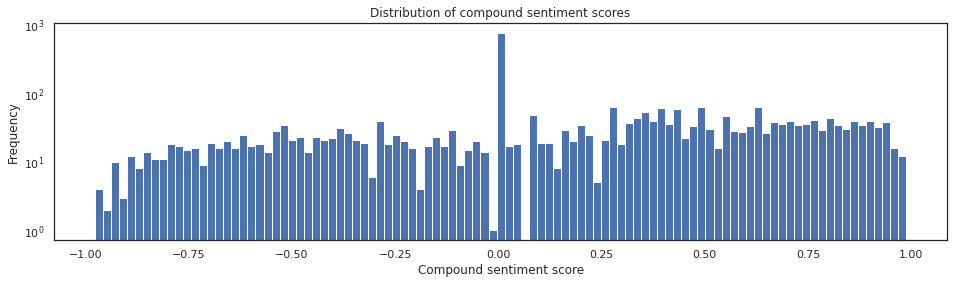

In [54]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
ax.hist(chunk['compound'], 101)
ax.set_title('Distribution of compound sentiment scores') 
ax.set_xlabel('Compound sentiment score')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

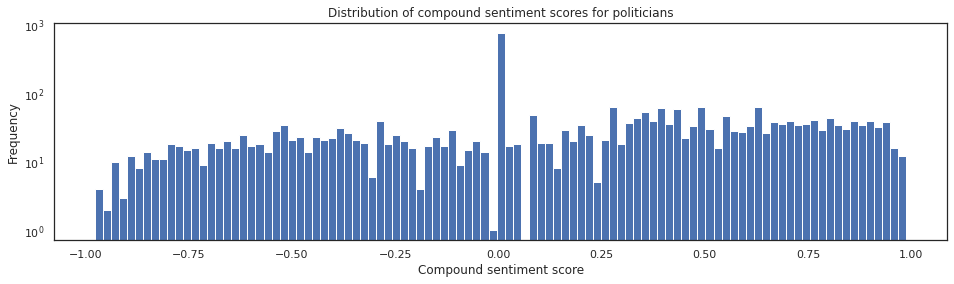

In [37]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
ax.hist(politicians['compound'], 101)
ax.set_title('Distribution of compound sentiment scores for politicians') 
ax.set_xlabel('Compound sentiment score')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
plt.show()

In [56]:
t, p = stats.ttest_ind(df_chunk['compound'], df_politicians['compound'])
print("Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for the overall.")
print(f"t-value: {round(t, 4)}, p-value: {round(p, 4)}")

Two sided paired t-test with null hypothesis: The mean mood for politicians is the same as the mean mood for the overall.
t-value: 3.5517, p-value: 0.0004
